# Классификация

Рассмотрим задачу классификации точек на плоскости $Ox_1x_2$. Любую точку на плоскости можно охарактеризовать её координатами $x_1$ и $x_2$. Эти координаты и примем за их признаковое описание. 

## Бинарная классификация

Для простоты будем считать, что все точки принадлежат одному из двух классов, а также что имеется выборка из $n$ точек, для которых известен этот самый класс. Назовем первый класс отрицательным, второй класс --- положительным. Поставим в соответствие всем точкам отрицательного класса значение $y_\mathrm{true} = -1$, а всем точкам положительного класса $y_\mathrm{true}= + 1$. Тогда известную выборку можно представить в виде следующей таблицы. 

| $x_1$       | $x_2$       | $y_\mathrm{true}$     |
| ----------- | ----------- | --------------------- |
| $x_1^1$     | $x_2^1$     | $y_\mathrm{true}^1$   |
| $\cdots$    | $\cdots$    | $\cdots$              |
| $x_1^n$     | $x_2^n$     | $y_\mathrm{true}^n$   |

Здесь верхний индекс соответствует номеру точки.

Необходимо на основе этих данных научиться классифицировать произвольную точку на плоскости, т.е. построить отображение $f\colon \mathbb{R}^2\to\{-1, 1\}$, которое бы хорошо классифицировало не только точки из известной выборки, но и остальные точки из $\mathbb{R}$.

Пока не будем уточнять, какой смысл вкладывается в "хорошо классифицировать".

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

folder = os.path.join("..", "_static", "lecture_specific", "ml")
plt.rcParams.update({"font.size": 16})

In [2]:

def plot_decision_boundary(classifier, data, ax, title=None, n_points=300):
    
    x_min, x_max = data["x1"].min(), data["x1"].max()
    y_min, y_max = data["x2"].min(), data["x2"].max()
    delta_x = (x_max - x_min) / 10
    delta_y = (x_max - x_min) / 10
    
    x = np.linspace(x_min - delta_x, x_max + delta_x, n_points)
    y = np.linspace(y_min - delta_y, y_max + delta_y, n_points)

    xx, yy = np.meshgrid(x, y)
    df = pd.DataFrame({
        "x1": xx.reshape(-1),
        "x2": yy.reshape(-1)
    })
    
    zz = classifier.predict(df)
    ax.contourf(xx, yy, zz.reshape(n_points, n_points), levels=1, cmap="Set2")
    sns.scatterplot(
        data=data, 
        x='x1', 
        y='x2', 
        hue='y', 
        s=100, 
        palette="bwr", 
        hue_norm=(-1, 1), 
        ax=ax
    )
    ax.set_title(title)
    

### Случай линейно разделимой выборки 

Один из самых простых случаев --- когда можно провести прямую (гиперплоскость в общем случае) таким образом, что все точки первого класса окажутся по одну сторону от неё, а все точки второго класса --- по другую. 

Ниже приводится пример такой выборки.

,x1,x2,y
0,1.228312,-0.757178,-1
1,0.698409,-1.380295,-1
2,2.548817,2.502258,1
3,0.573579,-1.352979,-1
4,0.585900,-1.337457,-1


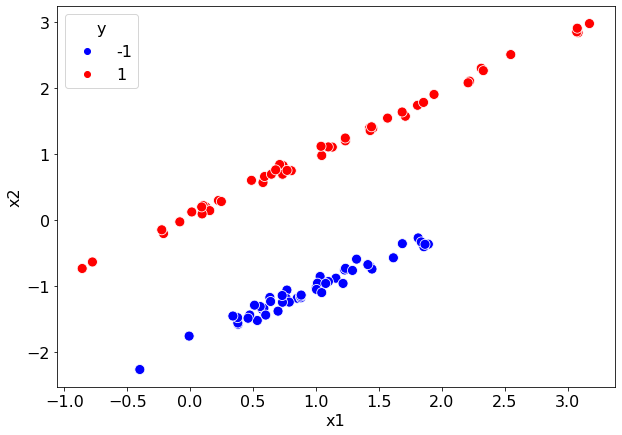

In [3]:
path = os.path.join(folder, "linearly_separable.csv")
data = pd.read_csv(path)

fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(
        data=data, 
        x='x1', 
        y='x2', 
        hue='y', 
        s=100, 
        palette="bwr", 
        hue_norm=(-1, 1), 
        ax=ax
    )
data.head()

Из построенной диаграммы рассеяния отчетливо видно, что классы можно отделить друг от друга прямой. 

В общем случае прямую можно задать уравнением 

$$
\omega_1 x_1 + \omega_2 x_2 + b = 0,
$$

а определить с какой стороны от неё находится точка с координатами $(x_1^*, x_2^*)$ можно по знаку величины $a(x_1^*, x_2^*) = \omega_1 x_1^* + \omega_2 x_2^* + b$. 

Значит можно задать классификатор 

$$
y_\mathrm{pred}(x_1, x_2) = \mathrm{sgn}\,(a(x_1, x_2)), 
$$

где $\mathrm{sgn}$ --- [функция сигнум](https://ru.wikipedia.org/wiki/Sgn).

Чисто теоретически можно подобрать коэффициенты $\vec{\omega} = (\omega_1, \omega_2)$ и $b$ в ручную. В ячейке ниже демонстрируется такой классификатор с $\omega_1=-1$, $\omega_2=1$ и $b=0.3$.

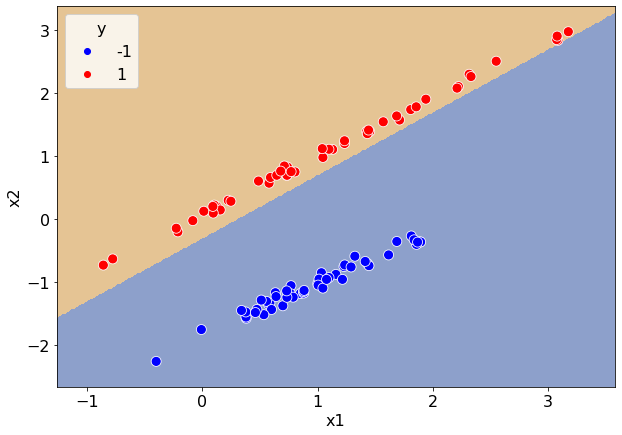

In [4]:
class ManualLinearClassifier:
    def __init__(self, weights, bias):
        self.weights = np.array(weights)
        self.bias = bias
        
    def predict(self, x):
        y = (self.weights @ x.T + self.bias).to_numpy()
        return np.sign(y)
    

classifier = ManualLinearClassifier([-1, 1], 0.3)

fig, ax = plt.subplots(figsize=(10, 7))
plot_decision_boundary(classifier, data, ax)

Даже такой простой классификатор успешно отделил все точки. Однако если бы это была многомерная задача, то подбирать коэффициенты вручную оказалось бы гораздо сложнее. Хочется каким-то образом обучить эти коэффициенты из данных. 

Это можно сделать, опираясь на уже рассмотренную задачу линейной регрессии. Подберем коэффициенты $(\vec\omega, b)$ таким образом, чтобы минимизировать среднее квадратичное отклонение 
$$
L(X_\mathrm{train}, \vec\omega, b) = \dfrac{1}{n}\sum_{i=1}^{n}(\omega_1 x_1^i + \omega_2 x_2^i + b - y^i)^2 \sim \min_{\substack{\vec\omega\in\mathbb{R}^2 \\ b\in\mathbb{R}}}.
$$ 

Код в ячейке ниже расширяет класс `LinearRegression` таким образом, чтобы метод `predict` возвращал не действительное число из $\mathbb{R}$, а только его знак. 

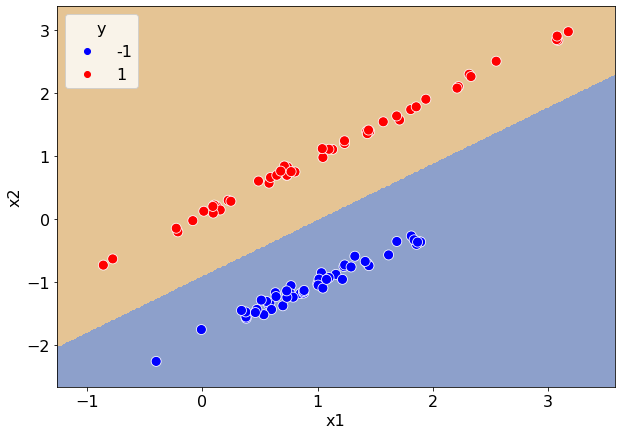

In [5]:
from sklearn.linear_model import LinearRegression

class RegressionClassifier(LinearRegression):
    def predict(self, x):
        y = super().predict(x)
        return np.sign(y)


regressor = RegressionClassifier()
regressor.fit(data[["x1", "x2"]], data["y"])

fig, ax = plt.subplots(figsize=(10, 7))
plot_decision_boundary(regressor, data, ax)

Видим, что удалось разумно разделить классы на основе линейной регрессии. Тем не менее обычно для решения задач классификации используют другие функции потерь. Одна из самых распространенных функций потерь --- [перекрестная энтропия](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F), которая в нашей задаче имеет вид

$$
L(p, y) = - (y \ln p + (1-y)\ln(1-p)).
$$

Здесь $p = \sigma(\omega_1 x_1 + \omega_2 x_2 + b) \in[0, 1]$ интерпретируется в качестве вероятности того, что точка $(x_1, x_2)$ принадлежит положительному классу, а $(1-p)$ --- в качестве вероятности того, что эта точка принадлежит отрицательному классу. Функция $\sigma$ --- [сигмоида](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0), значение которой в точке $x\in\mathbb{R}$ определяется формулой

$$
\sigma(x) = \dfrac{1}{1 + e^{-x}},
$$

которая принимает значения в интервале $(0, 1)$, монотонно растет и при этом 

$$
\begin{gathered}
\lim\limits_{x\to-\infty}\sigma(x)=0, \\
\lim\limits_{x\to+\infty}\sigma(x)=1.
\end{gathered}
$$
Это и позволяет интерпретировать значения этой функции в качестве вероятности.

Код в ячейке ниже строит графики сигмоиды, перекрестной энтропии и среднеквадратичной функции потерь.

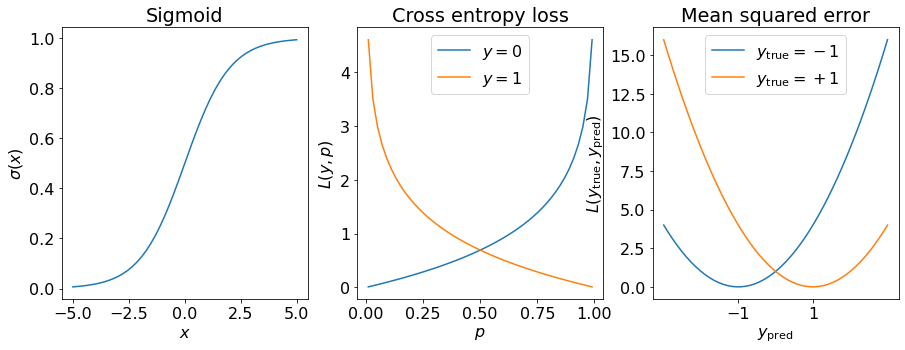

In [6]:
from scipy.special import expit as sigmoid
from sklearn.metrics import log_loss as cross_entropy_loss
from sklearn.metrics import mean_squared_error

fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

# sigmoid
x = np.linspace(-5, 5)
y = sigmoid(x)
axs[0].plot(x, y)
axs[0].set_title("Sigmoid")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$\sigma(x)$")

# cross entropy loss
probabilities = np.linspace(0.01, 0.99)
l0 = [cross_entropy_loss([0], [p], labels=[0, 1]) for p in probabilities]
l1 = [cross_entropy_loss([1], [p], labels=[0, 1]) for p in probabilities]
axs[1].plot(probabilities, l0, probabilities, l1)
axs[1].set_title("Cross entropy loss")
axs[1].set_xlabel("$p$")
axs[1].set_ylabel(r"$L(y, p)$")
axs[1].legend(["$y=0$", "$y=1$"])

# mean squared error
y_predictions = np.linspace(-3, 3)
l1 = [mean_squared_error([-1], [y_p]) for y_p in y_predictions]
l2 = [mean_squared_error([1], [y_p]) for y_p in y_predictions]
axs[2].plot(y_predictions, l1, y_predictions, l2)
axs[2].set_title("Mean squared error")
axs[2].set_xlabel(r"$y_\mathrm{pred}$")
axs[2].set_ylabel(r"$L(y_\mathrm{true}, y_\mathrm{pred})$")
axs[2].legend([r"$y_\mathrm{true}=-1$", r"$y_\mathrm{true}=+1$"])
_ = axs[2].set_xticks([-1, 1])

Функция перекрестной энтропии $L(y, p)$ определена на интервале $(0, 1)$ и в зависимости от значения $y$ монотонно растёт на этом интервале от 0 до бесконечности ($y=0$) или монотонно убывает от бесконечности до 0 ($y=1$). 

Значение $p$ интерпретируется в виде предсказанной вероятности какого-то события (в задаче классификации это вероятность того, что классифицируемый объект принадлежит классу с $y=1$), а $y$ считается истинной вероятностью. В связи с этим и рядом других факторов обученные с помощью перекрестной энтропии модели считают вероятностными.

Саму модель, использующую такую функцию потерь, называют [логистической регрессией](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F), а метод [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из библиотеки `scikit learn` её реализует. 

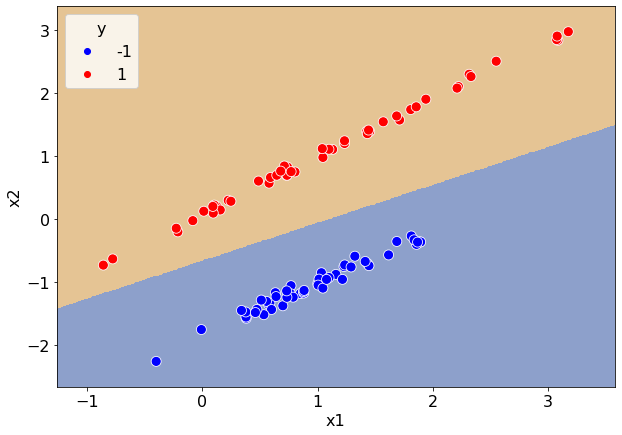

In [7]:
from sklearn.linear_model import LogisticRegression

log_classifier = LogisticRegression()
log_classifier.fit(data[["x1", "x2"]], data["y"])

fig, ax = plt.subplots(figsize=(10, 7))
plot_decision_boundary(log_classifier, data, ax)

Получили другую разделяющую прямую, а значит и другой классификатор. В общем случае нельзя однозначно сказать, какая из функций потерь лучше подойдет для конкретной задачи. 

Тем не менее продемонстрируем недостаток функции потерь `MSE` на чуть более сложных данных. Добавим к данным ещё одну точку положительного класса в глубину этого класса и посмотрим, как отреагирует классификаторы с разными функциями потерь.  

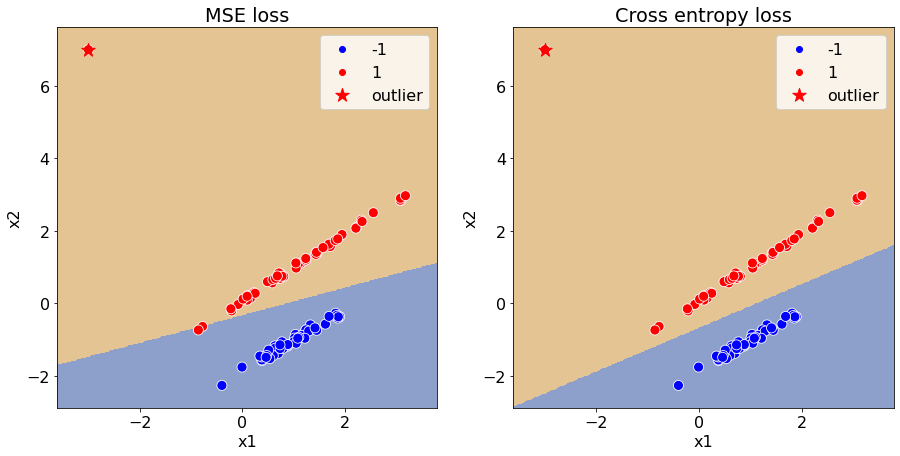

In [8]:
outlier = pd.DataFrame({"x1": -3, "x2": 7, "y": 1}, index=[100])
data_with_outlier = pd.concat([data, outlier])
X = data_with_outlier[["x1", "x2"]]
y = data_with_outlier["y"]

log_classifier.fit(X, y)
regressor.fit(X, y)

fig, axs = plt.subplots(figsize=(15, 7), ncols=2)


plot_decision_boundary(regressor, data_with_outlier, axs[0], title="MSE loss")
plot_decision_boundary(log_classifier, data_with_outlier, axs[1], title="Cross entropy loss")

for ax in axs: 
    ax.scatter(outlier.x1, outlier.x2, s=200, c="r", label="outlier", marker="*")
    ax.legend()

Классификатор с `MSE` функцией потерь резко отреагировал на добавление новой точки, хотя она была бы верно классифицирована и до этого. 

Чтобы объяснить этот эффект, рассмотрим величину $a(x_1^*, x_2^*) = \omega_1 x_1^* + \omega_2 x_2^* + b$, по знаку которой мы оцениваем класс точки $(x_1^*, x_2^*)$. Вектор $\vec\omega = (\omega_1, \omega_2)$ задаёт нормаль к прямой $\omega_1 x_1 + \omega_2 x_2+ b = 0$, а значит величина $a$ определяет насколько далеко точка располагается от разделяющей прямой: чем больше абсолютное значение этой величины, тем дальше эта точка от прямой.

![image](../../_static/lecture_specific/ml/margin_for_point.png)

Для заданной прямой и для любой точки $(x_1, x_2)$ из выборки можно ввести отступ $M(x_1, x_2, y_\mathrm{true}) = y_\mathrm{true} a(x_1, x_2)$. Величина $M$ положительна для верно классифицируемых точек и отрицательная для ошибочно классифицируемых точек, а абсолютное значение этой величины можно интерпретировать в качестве ступени уверенности классификатора, т.к. чем выше это значение, тем дальше точка находится от разделяющей прямой, а значит тем устойчивее она классифицируется: если разделяющую прямую немного изменить, то точка все равно останется с прежней стороны. Исходя из этого, можно ввести четыре категории точек:
1. точки с большим положительным значением $M$,  которые устойчиво классифицируются верно;
2. точки с небольшим положительным значением $M$, которые неустойчиво классифицируются верно;
3. точки с небольшим отрицательным значением $M$, которые неустойчиво классифицируются неверно;
4. точки с большим отрицательным значением $M$,  которые устойчиво классифицируются неверно;

Возвращаясь к функцией потерь `MSE`, заметим, что она штрафует за любое отклонения отступа $M$ от единицы, т.е. точки первой категории тоже штрафуются. Если же обратить внимание на функцию перекрестной энтропии, то она равна 0, только если $\sigma(M)=0$, т.е. $M=\infty$. Таким образом с точки зрения этой функции потерь чем выше отступ, тем лучше.

Назовем зазором классификатора расстояние от разделяющей поверхности до ближайшей точки из выборки $\min\limits_{i=1}^n M(x_1^i, x_2^i, y^i)$. [Метод опорных векторов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2) ищет классификатор с максимальным зазором. Функция [sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) позволяет найти такой линейный классификатор.

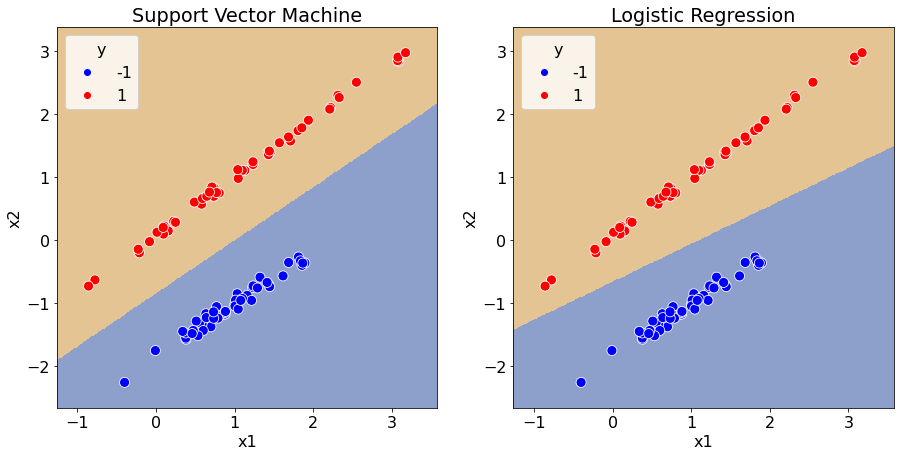

In [9]:
from sklearn.svm import LinearSVC


svm_classifier = LinearSVC()
svm_classifier.fit(data[["x1", "x2"]], data["y"])

fig, axs = plt.subplots(figsize=(15, 7), ncols=2)
plot_decision_boundary(svm_classifier, data, axs[0], title="Support Vector Machine")
plot_decision_boundary(log_classifier, data, axs[1], title="Logistic Regression")

### Случай не разделимой линейно выборки

Рассмотрим другую выборку, которую линейно разделить не выйдет.

<AxesSubplot:xlabel='x1', ylabel='x2'>

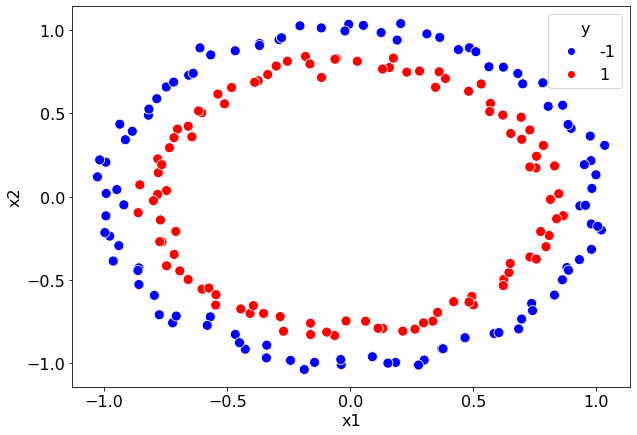

In [10]:
path = os.path.join(folder, "circles.csv")
data = pd.read_csv(path)

fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(
        data=data, 
        x='x1', 
        y='x2', 
        hue='y', 
        s=100, 
        palette="bwr", 
        hue_norm=(-1, 1), 
        ax=ax
    )

Исходя из диаграммы рассеяния очевидно, что разделить эту выборку прямой не выйдет. 

#### Конструирование признаков.

При решении задачи мы решили, что признаками точки будем считать координаты точки в декартовой системе координат. Такой выбор признакового описания точки можно считать произвольным: почему, например, не в полярной системе координат; почему только $x_1$ и $x_2$. 

В ячейке ниже определяется классификатор `RadiusLogisticClassifier`, который при обучении и оценивании класса вместо исходных признаков `x1` и `x2` использует признак радиуса `r`.

array([[-6.48857561]])

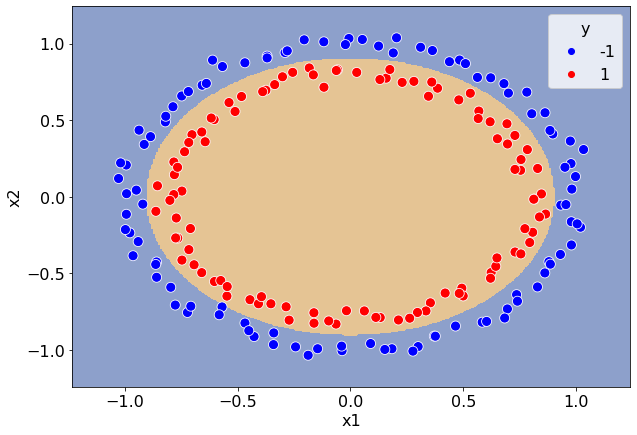

In [11]:
class RadiusLogisticClassifier(LogisticRegression):
    def get_radii(self, data):
        new_data = pd.DataFrame({
            "r": np.sqrt(data["x1"] ** 2 + data["x2"] ** 2)
        })
        return new_data
    
    def fit(self, data, targets):
        new_data = self.get_radii(data)
        super().fit(new_data, targets)
        
    def predict(self, data):
        new_data = self.get_radii(data)
        return super().predict(new_data)
        
classifier = RadiusLogisticClassifier()
classifier.fit(data[["x1", "x2"]], data["y"])

fig, ax = plt.subplots(figsize=(10, 7))
plot_decision_boundary(classifier, data, ax)

classifier.coef_

Практика показывает, что удачный набор признаков значительно упрощает задачу обучения алгоритма. Процесс составления признакового описания объектов называют  [конструированием признаков](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D1%81%D1%82%D1%80%D1%83%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2).

#### Нелинейные классификаторы

Поиск подходящего признакового описания требует экспертизы в решаемой задаче. Далеко не всегда очевидно, какие признаки будут полезны для классификации, а какие нет. В качестве альтернативы можно пробовать строить нелинейные классификаторы, которые по своей природе позволяет строить нелинейную разделяющую поверхность. 

В ячейке ниже на четырех выборках, три из которых линейно неразделимы, тестируются обучаются три нелинейных классификатора:
- метод ближайших соседей;
- деревья решений;
- нелинейный метод опорных векторов.

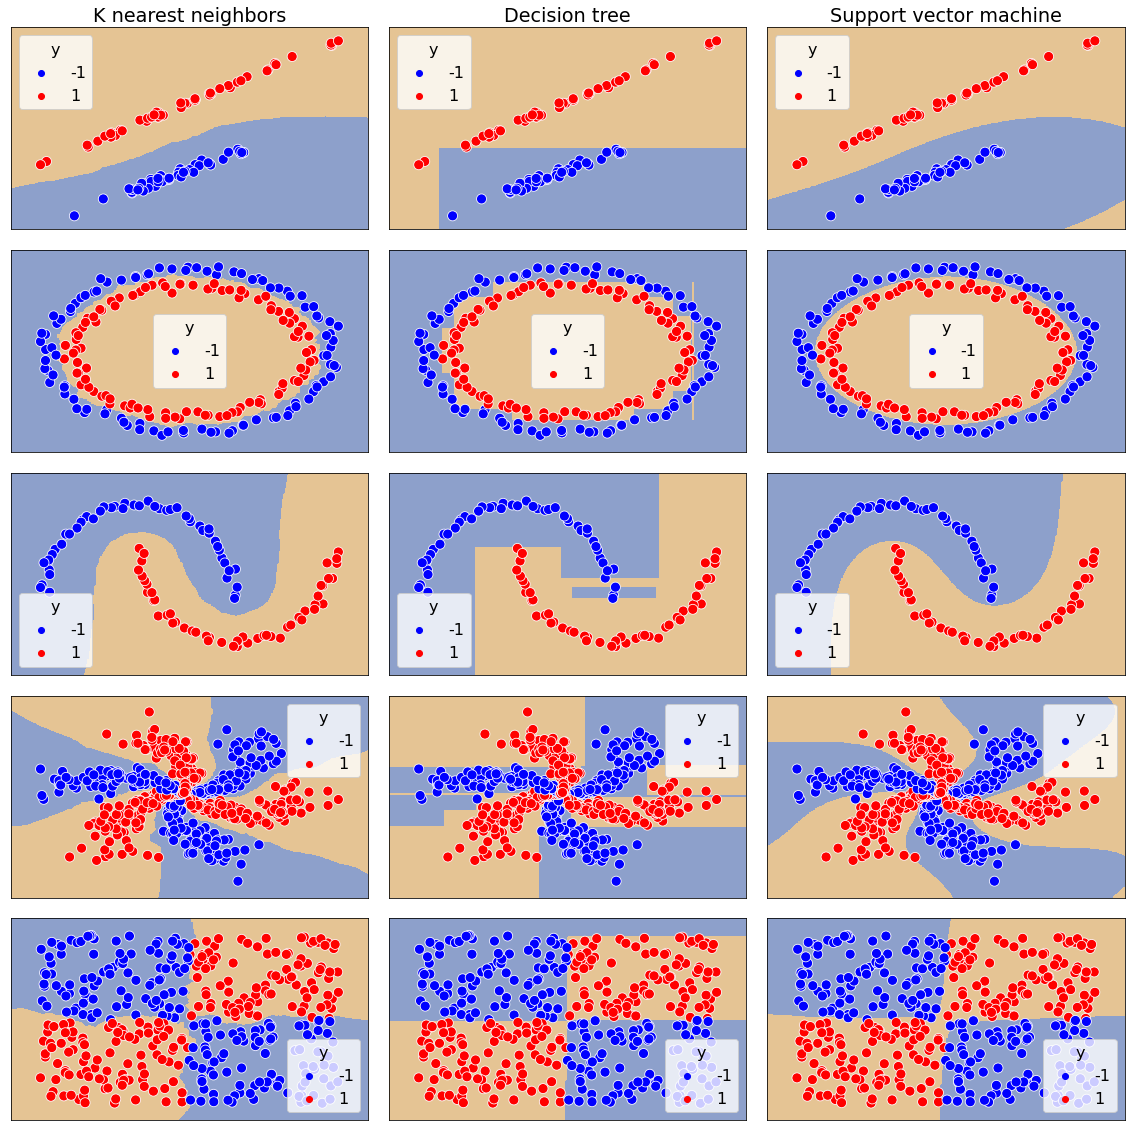

In [12]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

datasets = [
    pd.read_csv(os.path.join(folder, "linearly_separable.csv")),
    pd.read_csv(os.path.join(folder, "circles.csv")),
    pd.read_csv(os.path.join(folder, "moons.csv")),
    pd.read_csv(os.path.join(folder, "spirals.csv")),
    pd.read_csv(os.path.join(folder, "quadrant.csv"))
]

models = {
    "K nearest neighbors": KNeighborsClassifier(),
    "Decision tree": DecisionTreeClassifier(),
    "Support vector machine": SVC()
}

n_models = len(models)
n_datasets = len(datasets)
fig, axs = plt.subplots(figsize=(16, 16), nrows=n_datasets, ncols=n_models, layout="tight")

for i, (model_name, classifier) in enumerate(models.items()):
    for j, data in enumerate(datasets):
        classifier.fit(data[["x1", "x2"]], data["y"])
        plot_decision_boundary(classifier, data, axs[j, i])
        axs[j, i].xaxis.set_visible(False)
        axs[j, i].yaxis.set_visible(False)

    axs[0, i].set_title(model_name)
        


Выбор метода тоже является весьма не тривиальный задачей. Нередко пробуют как можно больше разных и выбирают тот, который демонстрирует лучшие показатели. 

### Метрики качества 

До сих пор мы обучали модели на всей выборке, а оценивали качество обученной модели визуально. В реальных ситуациях количество признаков обычно превышает два и визуально оценить качество модели невозможно. 


In [65]:
path = os.path.join(folder, "balanced.csv")
data = pd.read_csv(path)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      1000 non-null   float64
 1   f2      1000 non-null   float64
 2   f3      1000 non-null   float64
 3   f4      1000 non-null   float64
 4   f5      1000 non-null   float64
 5   f6      1000 non-null   float64
 6   f7      1000 non-null   float64
 7   f8      1000 non-null   float64
 8   f9      1000 non-null   float64
 9   f10     1000 non-null   float64
 10  y       1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 86.1 KB
None


Например, в примере выше у каждого объекта 10 признаков. В таких случаях используются различные метрики, значение которых вычисляется на выборках.

В ячейке ниже загруженная выборка делится сначала на две таблицы `X` и `Y`, где `X` --- таблица признаков, на основе которых классифицируются точки, а `Y` --- номера классов этих точек.

Затем каждая из этих таблиц делится на тренировочную и валидационную части.

In [66]:
from sklearn.model_selection import train_test_split

Y = data["y"]
X = data.drop("y", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7)

В ячейке ниже инициализируются 9 классификаторов, среди которых несколько классификаторов из библиотеки `scikit-learn`, а несколько наивных классификаторов:
- `ConstantClassifier` --- классификатор, который всегда выдает один и тот же класс, вне зависимости от входных данных;
- `RandomClassifier` --- классификатор, который пытается угадать класс, случайным образом выбирая номер класса.

Далее качество этих классификаторов будет оценивать с помощью разных метрик.

In [67]:
from abc import ABC, abstractmethod
from sklearn.ensemble import RandomForestClassifier

rng = np.random.default_rng()

class CustomClassifier:
    """
    abc for custom classifiers

    all of them should have methods fit and predict 
    so they can be used in the same context as sklearn classifiers
    """
    def fit(self, *args, **kwargs):
        pass

    @abstractmethod
    def predict(self, x):
        raise NotImplementedError()


class ConstantClassifier(CustomClassifier):
    def __init__(self, constant=0):
        self.constant = constant
    
    def predict(self, x):
        return self.constant * np.ones(shape=len(x))


class RandomClassifier(CustomClassifier):
    def predict(self, x):
        return rng.choice([0, 1], size=len(x), replace=True)


classifiers = {
    "always 0": ConstantClassifier(0),
    "always 1": ConstantClassifier(1),
    "random": RandomClassifier(),
    "logistic regression": LogisticRegression(),
    "linear SVM": LinearSVC(max_iter=10000),
    "nonlinear SVM": SVC(),
    "kNN": KNeighborsClassifier(), 
    "tree": DecisionTreeClassifier(),
    "random forest": RandomForestClassifier(),

}

for classifier in classifiers.values():
    classifier.fit(X_train, Y_train)

#### Ошибки первого и второго рода

Для произвольного бинарного классификатора на любой выборке можно вычислить следующие значения: 
- `TP` (`true positive`) --- количество корректно классифицированных объектов положительного класса;  
- `TN` (`true negative`) --- количество корректно классифицированных объектов отрицательного класса;
- `FP` (`false positive`) --- количество объектов отрицательного класса, для которых классификатор выдал положительный класс;
- `FN` (`false negative`) --- количество объектов положительного класса, для которых классификатор выдал отрицательный класс. 

|                           | $y_\mathrm{true} = -1$       | $y_\mathrm{true} = +1$     |
| ------------------------- | ---------------------------- | -------------------------- |
| $y_\mathrm{pred} = -1$    | `true negative`              | `false negative`           |
| $y_\mathrm{pred} = +1$    | `false positive`             | `true positive`            |

На главную диагональ этой таблицы попадают корректно классифицируемые объекты. Все ошибки сконцентрированы на побочной диагонали. При этом ложноположительные ошибки называют **ошибками первого рода**, а ложно отрицательные ошибки --- **ошибками второго рода**. 

Метод [sklearn.metric.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) принимает на вход массивы истинных классов и выхода классификатора, а возвращает матрицу, схожую с приведенной таблицей. Методом [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) удобно эти данные визуализировать.

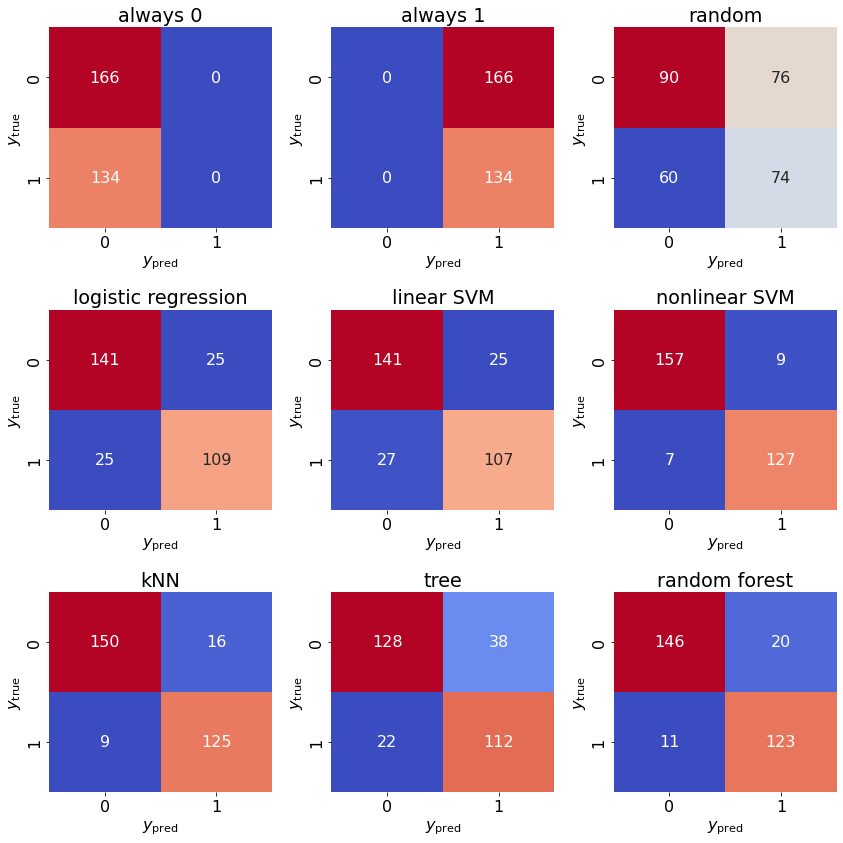

In [68]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ax, y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, ax=ax, cbar=False, cmap="coolwarm", fmt="d")
    ax.set_xlabel(r"$y_\mathrm{pred}$")
    ax.set_ylabel(r"$y_\mathrm{true}$")
    ax.set_title(title)

fig, axs = plt.subplots(figsize=(12, 12), nrows=3, ncols=3, layout="tight")
for ax, (name, clf) in zip(axs.flat, classifiers.items()):
    y_pred = clf.predict(X_test)
    plot_confusion_matrix(ax, Y_test, y_pred, name)

Такого рода таблицы очень полезны для анализа того, на каких классах чаще возникают ошибки. 

В качестве недостатка можно отметить, что в одной такой таблице минимум 4 числа, и не совсем понятно, как сравнивать качество моделей между собой на основе них.

#### Точность 

Самая простая метрика --- точность классификации, которая соответствует доли корректно классифицированных точек. 

Используя ранее введенные обозначения формулу для точности можно записать в виде
$$
\mathrm{accuracy} = \dfrac{\mathrm{TP} + \mathrm{TN}}{\mathrm{TP} + \mathrm{TN} + \mathrm{FP} + \mathrm{FN}}.
$$

Её преимущество относительно предыдущих таблиц заключается в том, что это одно всего одно число. Вычислить точность можно методом [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [69]:
from sklearn.metrics import accuracy_score 

def evaluate_accuracy(classifier, X, Y_true):
    Y_pred = classifier.predict(X)
    return accuracy_score(Y_true, Y_pred)


train_accuracies = {}
test_accuracies = {}
for model_name, classifier in classifiers.items():
    train_accuracies[model_name] = evaluate_accuracy(classifier, X_train, Y_train)
    test_accuracies[model_name] = evaluate_accuracy(classifier, X_test, Y_test)

metrics = pd.DataFrame({
    "train accuracy": pd.Series(train_accuracies), 
    "test accuracy": pd.Series(test_accuracies)
})

metrics

,train accuracy,test accuracy
always 0,0.478571,0.553333
always 1,0.521429,0.446667
random,0.510000,0.496667
logistic regression,0.834286,0.833333
linear SVM,0.834286,0.826667
nonlinear SVM,0.940000,0.946667
kNN,0.958571,0.916667
tree,1.000000,0.800000
random forest,1.000000,0.896667


Недостаток такой метрики тот же, что и её преимущество: это всего лишь одно число. Например, вычислив точность классификации, мы потеряли информацию о том, какого рода ошибки чаще встречаются.

#### Несбалансированные выборки

Если классы представлены в выборке неравномерно, то метрика точности может оказаться практически бесполезной. В качестве демонстрации рассмотрим следующую ситуацию. Пусть 99% выборки --- объекты первого отрицательного класса, а оставшийся 1%  --- объекты положительного класса. Тогда выдающий всегда отрицательный класс классификатор будет иметь точность 99%, т.к. он будет ошибаться только на объектах положительного класса, коих всего 1%.

Несбалансированные выборки часто возникают при поиска аномалий, медицинских данных, обнаружении атак и т.д. В таких ситуациях принято рассматривать другие метрики. Часто смотрят на метрики `precision` (точность) и `recall` (полнота), которые определяются формулами

$$
\begin{aligned}
\mathrm{precision}& = \dfrac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}, \\
\mathrm{recall}& = \dfrac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}.
\end{aligned}
$$

Смысл этих метрик легко понять, если провести аналогию с медицинским тестированием на редкое заболевание. Пусть положительный класс --- множество людей действительно больных заболеванием, а отрицательный класс --- остальные люди. Тест может давать положительный (болен) и отрицательный результат (не болен). Тогда 
- полнота  (`recall` или чувствительность в медицине) --- доля больных, которым тест выдал корректный результат. Чем выше чувствительность (полнота), тем вероятнее этот тест обнаружит больного. 
- точность (`precision`) --- доля действительно больных пациентов среди пациентов с положительным тестом. Чем выше точность теста, тем выше вероятность того, что пациент действительно болен, если его тест дал положительный результат.
- вместо точности в медицине используют метрику специфичности теста ($\mathrm{specificity} = \frac{\mathrm{TN}}{\mathrm{FP} + \mathrm{TN}}$), которая характеризует в какой степени тест специфичен именно к данному заболеванию. 

В ячейке ниже загружается выборка, в которой соотношение положительного класса к отрицательному 1:9.

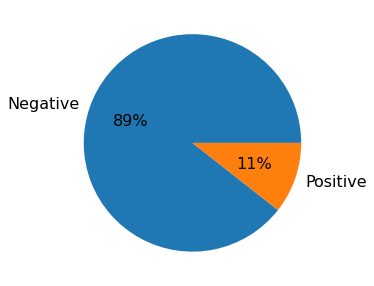

In [70]:
path = os.path.join(folder, "unbalanced.csv")
data = pd.read_csv(path)
classes_representation = data["y"].value_counts()


fig, ax = plt.subplots(figsize=(5, 5))
labels = ["Negative", "Positive"]
ax.pie(classes_representation, labels=labels, autopct="%.0f%%")

Y = data["y"]
X = data.drop("y", axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7)

В следующей ячейке вычисляются `accuracy`, `recall` и `precision` для того же списка моделей, что фигурировал при обучении на сбалансированной выборке.

- для вычисления `precision` используется [sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html);
- для вычисления `recall` используется [sklearn.metrics.recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html).

In [72]:
from sklearn.metrics import precision_score, recall_score

def evaluate_precision(classifier, X, Y_true):
    Y_pred = classifier.predict(X)
    return precision_score(Y_true, Y_pred, zero_division=1)

def evaluate_recall(classifier, X, Y_true):
    Y_pred = classifier.predict(X)
    return recall_score(Y_true, Y_pred)

accuracies = {}
precisions = {}
recalls = {}
for model_name, classifier in classifiers.items():
    classifier.fit(X_train, Y_train)
    accuracies[model_name] = evaluate_accuracy(classifier, X_test, Y_test)
    precisions[model_name] = evaluate_precision(classifier, X_test, Y_test)
    recalls[model_name] = evaluate_recall(classifier, X_test, Y_test)


metrics = pd.DataFrame({
    "accuracy": pd.Series(accuracies),
    "precision": pd.Series(precisions),
    "recall": pd.Series(recalls),
})

metrics

,accuracy,precision,recall
always 0,0.891667,1.000000,0.000000
always 1,0.108333,0.108333,1.000000
random,0.523333,0.111486,0.507692
logistic regression,0.940000,0.853659,0.538462
linear SVM,0.938333,0.868421,0.507692
nonlinear SVM,0.951667,0.928571,0.600000
kNN,0.948333,0.840000,0.646154
tree,0.930000,0.676923,0.676923
random forest,0.953333,0.893617,0.646154


Из этой таблицы видно, что выдающий всегда отрицательный класс классификатор `always 0` имеет `accuracy` равную 89.5%, но нулевую полноту. Построим диаграмму рассеивания для показателей `precision` и `recall` по типам моделей.

<AxesSubplot:xlabel='precision', ylabel='recall'>

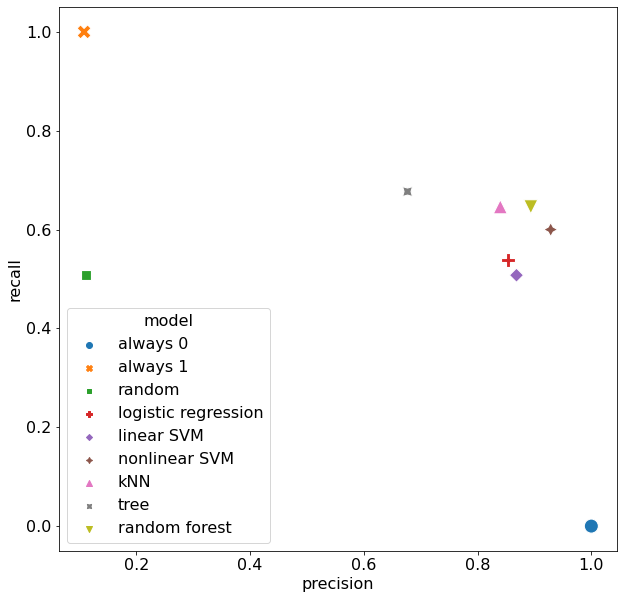

In [74]:
metrics["model"] = metrics.index

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=metrics, x="precision", y="recall", hue="model", style="model", s=200, ax=ax)